# FGC for Big Datasets

In this tutorial we want to show how we can use FGC with big datasets. The base of FGC is the symmetric proximity matrix calculated for the trained Random Forest model. In case of many samples in your dataset, the calculation of the matrix, the bootstrapping of it (in the process of finding the optimal cluster number), as well as finding k clusters with the k-Medoids algorithm can get computationally demanding. Here, we want to show you what you can do to speed-up the process and get the insights you need on your big dataset with the help of FGC. 

Keep in mind that when FGC is asked to optimize the cluster number, i.e. when the number_of_clusters = None (default), it will compute the cluster labels for each possible k (up to ```max_K```) and for each of ```bootstraps_JI``` bootstrap samples which can lead to a lot of runs of the K-Medoids algorithm in the background. For example, for checking whether 2, 3, 4 or 5 is the optimal cluster number for your dataset with 100 bootstrap iterations for Jaccard Index calculation, the K-medoids will be called 4 + 4*100 = 404 times. Moreover, the bigger your dataset in terms of number of samples (N), the bigger is the distance matrix (N x N) the K-Medoids algorithm needs to work with. Hence, it is definitely worth thinking how to speed up the whole process.

**Note:** the timing also depends on your compute resources, hence, if you rerun those cells it might differ. However, the reuntime reduction should stay proportional.

**Note:** for installation description and a general introduction to FGC please have a look at [Read the Docs - Installation]() and [Introduction Notebook]()

**Imports:**

In [1]:
## Import the Forest-Guided Clustering package
from fgclustering import FgClustering

## Imports for datasets
from sklearn.datasets import fetch_california_housing

## Additional imports for use-cases

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import pandas as pd
import timeit

In this Special Case, we will again be using the California housing dataset which was with its 20,640 samples already big enough to significantly slow down the process. We will train the Random Forest model on the full dataset, but will reduce the number of samples to 1000 for the inference with FGC for illustration and timing.

In [2]:
# Load the data
data_housing = fetch_california_housing(as_frame=True).frame

# Train the model (same code as in the Use Case 3)
X_housing = data_housing.loc[:, data_housing.columns != 'MedHouseVal']
y_housing = data_housing.MedHouseVal

regressor = RandomForestRegressor(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_regressor = GridSearchCV(regressor, grid, cv=5)
grid_regressor.fit(X_housing, y_housing)
rf_housing = grid_regressor.best_estimator_

print(f'Parameters of best prediction model: {grid_regressor.best_params_}')
print(f'OOB R^2 of prediction model: {round(rf_housing.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'log2'}
OOB R^2 of prediction model: 0.663


In [3]:
# Reduce the dataset size for FGC:
data_housing_fgc = data_housing.iloc[:1000]

# create the fgc object
fgc = FgClustering(model=rf_housing, data=data_housing_fgc, target_column='MedHouseVal')

Interpreting RandomForestRegressor


First, we will time the default FGC run to be able to compare it to the faster setup we will introduce below. We will change the default settings for the number of bootstrap samples for Jaccard index calculation to 50 and the maximum K value to 7 (```bootstraps_JI``` and ```max_K```, respectively). Other parameters are kept default, but below we are emphasising the ones that will need to be changed later on: 

In [4]:
# verbose = 0 for no output from fgc
timeit.timeit(lambda: fgc.run(method_clustering = 'pam', max_K = 7, bootstraps_JI = 50, n_jobs = 1, discart_value_JI = 0.75, verbose = 0), number=10)

Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5


240.98910198499652

As you see, for our __current set-up__ FGC needed on average __240.9 seconds__. This will be our baseline for further comparison.

**Parallelize the boostrapping process by setting n_jobs > 1**

Use the cores you have at your disposal to parallelize the calculation of Jaccard index across bootstrapped samples. You can do so by specifying the parameter ```n_jobs``` in the ```run()``` function. Special cases involve:
- If 1 is given, no parallel computing code is used at all, which is a default setup in FGC
- -1 means using all processors

Now, we will run the same fgc set-up as above, but with 5 (```n_jobs```) concurrently running jobs: 


In [5]:
timeit.timeit(lambda: fgc.run(method_clustering = 'pam', max_K = 7, bootstraps_JI = 50, n_jobs = 5, discart_value_JI = 0.75, verbose = 0), number=10)

Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5


95.20838142600405

By specifying the __n_jobs > 1__, i.e. running some __jobs in parallel__, we increased the speed of FGC and now it needed __95.2 seconds__ on average.

**Use _fasterpam_ method for K-Medoids**

[k-medoids package](https://python-kmedoids.readthedocs.io/en/latest/) offers a fast implementation of _PAM_ method used in K-Medoids algorithm. Specifying the ```method_clustering``` parameter in the ```run()``` function will do the trick for you and make the process of calculating cluster labels in FGC much faster. 

Compared to our baseline run, we will change only the ```method_clustering``` to _fasterpam_:

In [6]:
timeit.timeit(lambda: fgc.run(method_clustering = 'fasterpam', max_K = 7, bootstraps_JI = 50, n_jobs = 1, discart_value_JI = 0.75, verbose = 0), number=10)

Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5


49.07597594500112

Compared to baseline example, changing only the __method_clustering__ to __fasterpam__ increased the speed of FGC - now it needed __49.1 seconds__ on average.

**Note:** See how across different iterations done for timing purposes, FGC was not super consistent with the cluster number chosen. However, keep in mind we are using just 1000 samples, while the Random Forest model was trained on 20,640 and we also reduced the number of bootstrap samples, which with that sample number might not be enough.

**Combine the approaches if possible**  

We find it best, if possible of course, to combine both of the above aspects: 

In [7]:
timeit.timeit(lambda: fgc.run(method_clustering = 'fasterpam', max_K = 7, bootstraps_JI = 50, n_jobs = 5, discart_value_JI = 0.75, verbose = 0), number=10)

Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5
Optimal number of cluster is: 5


42.93332568799815

Compared to baseline example, changing both the __method_clustering__ to __fasterpam__ and setting __n_jobs >1__ increased the speed of FGC - now it needed __42.9 seconds__ on average. Hence, this strategy is a clear winner in our example and this difference should get even larger with larger matrices.

**Subsampling**

In case none of the above speed-up tips work for you because your dataset is simply that big or you don't have enough compute resources, you can try a subsampling strategy we will briefly introduce here. Of course, combining it with any of the previous approaches is possible.

We will assume that you do not know the cluster number in your data and that you want FGC to optimize it. What you could do is approximate the cluster number by subsampling your dataset as many times you want and decide on the cluster number by taking the majority vote from the iterations (just like the Random Forest Classifier takes the majority vote across the trees for the class prediction). 

**Note:** the number of iterations and subsample size should be set-up properly and with the total number of samples in mind. If you set the sample size and number of iterations to too low numbers, you might not get the good approximation of your big dataset. 

We will use the same data as before, reduced in size for the sake of this example:

In [8]:
# Reduce the dataset size for FGC:
data_housing_fgc = data_housing.iloc[:1000]

# create the fgc object
fgc = FgClustering(model=rf_housing, data=data_housing_fgc, target_column='MedHouseVal')

Interpreting RandomForestRegressor


In [9]:
number_of_iterations = 20   # Number of times dataset will be subsampled
sample_size = 300           # Number of samples in the subsampled dataset
max_K = 7                   # Maximum K for the FGC

k_result =  dict((i,0) for i in range(1, max_K)) # Dictionary to store the result

for i in range(number_of_iterations):
    # sample the dataset
    data_sample = data_housing_fgc.sample(n = sample_size, replace = False, random_state = i) # setting random state for reproducibility
    # instantiate the fgc object on the subsampled dataset and run it: 
    fgc = FgClustering(model=rf_housing, data=data_sample, target_column='MedHouseVal')
    fgc.run(method_clustering = 'pam', max_K = max_K, discart_value_JI = 0.75, bootstraps_JI = 100, n_jobs = 1, verbose = 0)
    # save the result
    k_result[fgc.k] += 1


Interpreting RandomForestRegressor
Optimal number of cluster is: 2
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 3
Interpreting RandomForestRegressor
Optimal number of cluster is: 3
Interpreting RandomForestRegressor
Optimal number of cluster is: 4
Interpreting RandomForestRegressor
Optimal number of cluster is: 4
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 2
Interpreting RandomForestRegressor
Optimal number of cluster is: 3
Interpreting RandomForestRegressor
Optimal number of cluster is: 2
Interpreting RandomForestRegressor
Optimal number of cluster is: 6
Interpreting RandomForestRegressor
Optimal number of cluster is: 5
Interpreting RandomForestRegressor
Optimal number of cluster is: 2
Interpreting RandomForestRegressor
Optimal number of cluster i

Check the results:

In [11]:
pd.DataFrame(k_result.items(), columns=['k','count']).sort_values(by='count', ascending=False).reset_index(drop=True)

,k,count
0,5,7
1,2,5
2,3,4
3,4,3
4,6,1
5,1,0


We see that the cluster number 5 was chosen most of the time, but it is closely followed by 2. As mentioned before, you should have enough subsamples and iterations to get the good approximation or increase the number of bootstrap samples in the FGC which was here all set to lower values for the sake of example. However, if the situation between the cluster numbers is not clear, you should inspect further. After all, in the clustering analysis with the real datasets, answering the question of optimal number of clusters is not trivial.

After you get the approximated cluster number from your iterations or further inspections, you can fit FGC with the given number of clusters on your full dataset. Now, this should be faster since there is no optimization happening, i.e there are no bootstrap iterations for Jaccard index calculation. Hence, the K-Medoids algorithm is called one time on the original distance matrix calculated in the background:

In [12]:
fgc = FgClustering(model=rf_housing, data=data_housing_fgc, target_column='MedHouseVal')
fgc.run(number_of_clusters = 5, method_clustering = 'pam', max_K = max_K, bootstraps_JI = 100, n_jobs = 1, verbose = 0)

Interpreting RandomForestRegressor
Use 5 as number of cluster


Now, you can do all the visualisations and further inspections as we did before to get the insights from your big dataset:

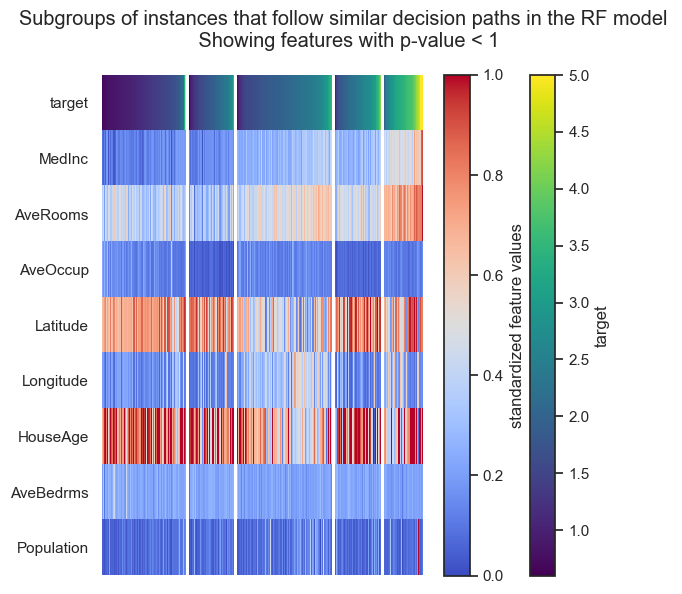

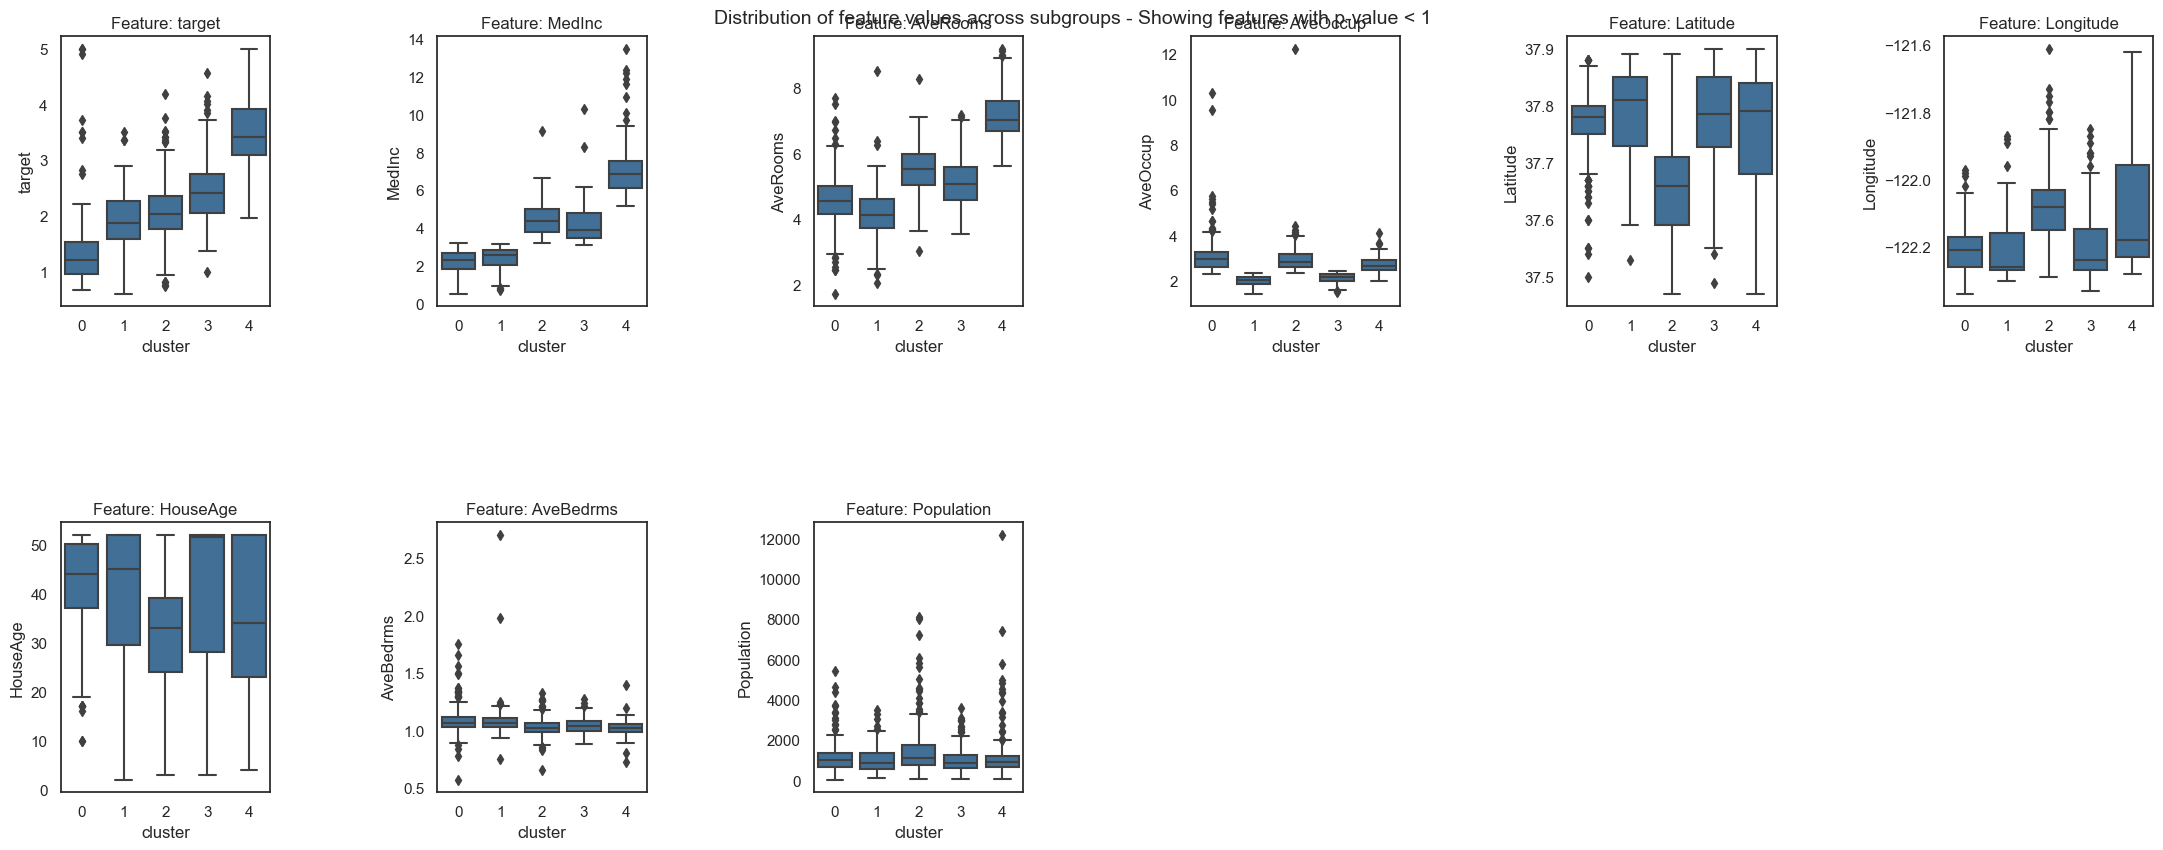

In [13]:
fgc.plot_decision_paths()